In [0]:
#import necessary packages
import os

import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

use_cuda = True

In [0]:
#function to plot results

def plot_fit_history(history):
  tr_acc = history['acc']
  val_acc = history['val_acc']
  tr_loss = history['loss']
  val_loss = history['val_loss']
  epochs_range = range(1, len(tr_acc) + 1)
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss', color=color)
  l1, = ax1.plot(epochs_range, tr_loss, 's:', color=color, label='Training Loss', markeredgewidth=1, fillstyle='none')
  l2, = ax1.plot(epochs_range, val_loss, 'o-', color=color, label='Validation Loss')
  ax1.tick_params(axis='y', labelcolor=color, grid_color=color, grid_linestyle=':')

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
  l3, = ax2.plot(epochs_range, tr_acc, 's:', color=color, label='Training Acc', markeredgewidth=1, fillstyle='none')
  l4, = ax2.plot(epochs_range, val_acc, 'o-', color=color, label='Validation Acc')
  ax2.tick_params(axis='y', labelcolor=color, grid_color=color, grid_linestyle=':')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  
  plt.legend((l1, l2, l3, l4), ('Training Loss', 'Validation Loss', 'Training Acc', 'Validation Acc'), loc=(1.2,0.5))
  plt.show()

In [5]:
class DataSet:
  def __init__(self, songs):
    # list of songs
    self.s = songs
    # number of notes in each song
    self.n_s = []
    for s0 in songs:
      self.n_s.append(s0.shape[0])
    self.n_s = np.array(self.n_s)
    # total number of notes in all songs
    self.n_t = self.n_s.sum()
    # number of songs
    self.n_n = len(self.s)
    # all nodes as one sequence
    self.orig_data = np.concatenate(self.s)

# list of all songs from the datafile
s = []

with open('music.txt') as fp:
  for cnt, line in enumerate(fp):
    s0 = np.fromstring(line, sep=" ", dtype=int)
    s.append(s0)

full_set = DataSet(s)

print(full_set.n_t)

print(full_set.orig_data.shape)

1553149
(1553149,)


In [6]:
#preprocessing

# class index to class label mapping
data_dict = np.unique(full_set.orig_data);

dim = len(data_dict)

# class label to class index mapping
label_to_int = dict((l, i) for i, l in enumerate(data_dict))

# one-hot encoding from class indices
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[targets]
    return res.reshape(list(targets.shape)+[nb_classes])

# encoding full DataSet
# by adding new attributes to the data structure
full_set.int_s = []
full_set.one_hot_s = []
for s0 in full_set.s:
  int_tmp = np.array([label_to_int[l] for l in s0], dtype=int)
  # data as class indices
  full_set.int_s.append(int_tmp)
  # data as one-hot vectors
  full_set.one_hot_s.append(get_one_hot(int_tmp, dim))

print(full_set.one_hot_s[0].shape)

(1004, 89)


In [0]:
#740 songs in total. I have taken first 50 songs as validation set. The rest is training set

n_validation_songs = 50

val_d = DataSet(s[0:n_validation_songs])
val_d.int_s = full_set.int_s[0:n_validation_songs]
val_d.one_hot_s = full_set.one_hot_s[0:n_validation_songs]

tr_d =  DataSet(s[n_validation_songs:])
tr_d.int_s = full_set.int_s[n_validation_songs:]
tr_d.one_hot_s = full_set.one_hot_s[n_validation_songs:]

In [8]:
print(val_d.one_hot_s[0].shape)

(1004, 89)


In [0]:
batch = 64
timelapse = 32

def generator(data, b=batch, t=timelapse):
  n_t_p = data.n_t - data.n_n*(t+1)
  n_s_p = data.n_s - (t+1)
  while True:
    samples = np.zeros((b, t, dim))
    targets = np.zeros((b)) 
    for k in range (b):
      i = random.randrange(0, n_t_p)
      j = 0;
      while i >= n_s_p[j]:
         i -= n_s_p[j]
         j += 1
      samples[k] = data.one_hot_s[j][i:i+t]
      targets[k] = data.int_s[j][i+t]

    yield samples, targets

In [0]:
class Model(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden = self.init_hidden()

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the dense layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input.view(-1, self.batch_size, self.input_dim))
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [0]:
sample_size = tr_d.n_t - timelapse*tr_d.n_n
val_size = val_d.n_t - timelapse*val_d.n_n

h_dim = 512
model = Model(dim, h_dim, batch, dim, 2)
if use_cuda and torch.cuda.is_available():
    model.cuda()

In [0]:
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.RMSprop(model.parameters(), lr=learning_rate)

In [0]:
hist = {"acc": [], "loss": [], "val_loss": [], "val_acc": []}


def train(num_epochs, tr_gen, val_gen):
  for t in range(num_epochs):
    correct = 0
    total = 0
    for b1 in range(0, sample_size, batch*timelapse):
      
      # Clear stored gradient
      model.zero_grad()
      optimiser.zero_grad()

      # Forward pass
      x_batch, y_batch = next(tr_gen)
      x_batch = torch.from_numpy(np.swapaxes(x_batch, 0, 1)).float()
      y_batch = torch.from_numpy(y_batch).long()
      if use_cuda and torch.cuda.is_available():
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
      y_pred = model(x_batch)
      _, predicted = torch.max(y_pred.data, 1)
      labels = y_batch
      correct += (predicted.cpu() == labels.cpu()).sum()
      total += labels.size(0)
      loss = loss_fn(y_pred, y_batch)
      if b1 == 0:
        # print(y_pred.shape)
        print("Epoch ", t, "Loss: ", loss.item())
      currloss = loss.item()

      # Backward pass
      loss.backward()

      # Update parameters
      optimiser.step()
    
    accuracy = 100 * correct.item() / total
    hist["loss"].append(currloss)
    hist["acc"].append(accuracy)
    print("acc: ", accuracy)

    # Validation
    correct = 0
    total = 0
    loss = 0
    n_b = 0
    with torch.no_grad():
      for b in range(0, val_size, batch*timelapse):
        x_batch, y_batch = next(val_gen)
        x_batch = torch.from_numpy(np.swapaxes(x_batch, 0, 1)).float()
        y_batch = torch.from_numpy(y_batch).long()
        if use_cuda and torch.cuda.is_available():
          x_batch = x_batch.cuda()
          y_batch = y_batch.cuda()
        y_pred = model(x_batch)
        _, predicted = torch.max(y_pred.data, 1)
        labels = y_batch
        correct += (predicted.cpu() == labels.cpu()).sum()
        total += labels.size(0)
        loss += loss_fn(y_pred, y_batch)
        n_b += 1
      accuracy = 100 * correct.item() / total
      loss = loss.item() / n_b 
    hist["val_loss"].append(loss)
    hist["val_acc"].append(accuracy)
    print("Val acc: ", accuracy, "Val loss: ", loss)

In [0]:
gen = generator(tr_d)
vgen = generator(val_d)

In [15]:
train(50, gen, vgen)

Epoch  0 Loss:  4.484646320343018
acc:  3.1658356258596974
Val acc:  3.977272727272727 Val loss:  3.739230069247159
Epoch  1 Loss:  3.718900680541992
acc:  3.3291781292984868
Val acc:  3.3380681818181817 Val loss:  3.7750670693137427
Epoch  2 Loss:  3.9447288513183594
acc:  4.451083218707015
Val acc:  4.971590909090909 Val loss:  3.544797030362216
Epoch  3 Loss:  3.7132580280303955
acc:  5.3494669876203575
Val acc:  5.5397727272727275 Val loss:  3.5619694102894175
Epoch  4 Loss:  3.551619291305542
acc:  6.041523383768913
Val acc:  6.9602272727272725 Val loss:  3.4519129666415127
Epoch  5 Loss:  3.3717384338378906
acc:  7.004384456671252
Val acc:  6.889204545454546 Val loss:  3.4251618818803267
Epoch  6 Loss:  3.722745180130005
acc:  7.644859009628611
Val acc:  5.3977272727272725 Val loss:  3.418493791060014
Epoch  7 Loss:  3.41579532623291
acc:  8.367004814305364
Val acc:  7.244318181818182 Val loss:  3.360512126575817
Epoch  8 Loss:  3.589237928390503
acc:  9.005330123796425
Val acc: 

In [16]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/3
train(25, gen, vgen)

Epoch  0 Loss:  2.250041961669922
acc:  35.61726272352132
Val acc:  22.017045454545453 Val loss:  2.728979457508434
Epoch  1 Loss:  2.4869673252105713
acc:  36.37809491059147
Val acc:  23.295454545454547 Val loss:  2.6635095422918145
Epoch  2 Loss:  2.1592531204223633
acc:  36.45116918844567
Val acc:  25.994318181818183 Val loss:  2.7413401170210405
Epoch  3 Loss:  2.161864995956421
acc:  36.840182255845946
Val acc:  23.72159090909091 Val loss:  2.7173080444335938
Epoch  4 Loss:  2.4693636894226074
acc:  37.160419532324624
Val acc:  23.15340909090909 Val loss:  2.7357241890647193
Epoch  5 Loss:  1.8562067747116089
acc:  37.381791609353506
Val acc:  24.21875 Val loss:  2.7336930361661045
Epoch  6 Loss:  2.347722291946411
acc:  37.71922283356258
Val acc:  27.05965909090909 Val loss:  2.6422726024280894
Epoch  7 Loss:  1.9892797470092773
acc:  37.89761004126547
Val acc:  24.21875 Val loss:  2.7217369079589844
Epoch  8 Loss:  2.251537561416626
acc:  38.58966643741403
Val acc:  26.349431818

In [17]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/9
train(25, gen, vgen)

Epoch  0 Loss:  1.9302418231964111
acc:  42.058545392022005
Val acc:  26.06534090909091 Val loss:  2.6888100017200816
Epoch  1 Loss:  2.276036500930786
acc:  42.2175894085282
Val acc:  26.06534090909091 Val loss:  2.6940617994828657
Epoch  2 Loss:  2.3178350925445557
acc:  42.65603507565337
Val acc:  24.360795454545453 Val loss:  2.7019188620827417
Epoch  3 Loss:  2.243666172027588
acc:  43.06868982118294
Val acc:  25.213068181818183 Val loss:  2.7199264873157847
Epoch  4 Loss:  2.1562604904174805
acc:  43.14606258596974
Val acc:  25.142045454545453 Val loss:  2.7095616080544214
Epoch  5 Loss:  1.9102855920791626
acc:  43.28791265474553
Val acc:  24.147727272727273 Val loss:  2.7063383622602983
Epoch  6 Loss:  2.4775307178497314
acc:  43.03000343878955
Val acc:  25.78125 Val loss:  2.6750533364035864
Epoch  7 Loss:  2.126250982284546
acc:  43.42116574965612
Val acc:  25.49715909090909 Val loss:  2.6282608725807886
Epoch  8 Loss:  1.5471056699752808
acc:  43.83167125171939
Val acc:  26.

In [18]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/27
train(25, gen, vgen)

Epoch  0 Loss:  1.6897401809692383
acc:  45.748796423658874
Val acc:  24.289772727272727 Val loss:  2.759458541870117
Epoch  1 Loss:  2.4734578132629395
acc:  45.16635144429161
Val acc:  26.207386363636363 Val loss:  2.7014857205477627
Epoch  2 Loss:  2.092846155166626
acc:  45.76599037138927
Val acc:  24.360795454545453 Val loss:  2.6927880373868076
Epoch  3 Loss:  1.7651863098144531
acc:  45.3683803301238
Val acc:  26.349431818181817 Val loss:  2.69490571455522
Epoch  4 Loss:  2.3224334716796875
acc:  45.3167984869326
Val acc:  24.50284090909091 Val loss:  2.743644194169478
Epoch  5 Loss:  2.263624429702759
acc:  45.76599037138927
Val acc:  24.786931818181817 Val loss:  2.745306535200639
Epoch  6 Loss:  1.9385589361190796
acc:  45.48443947730399
Val acc:  25.710227272727273 Val loss:  2.769843881780451
Epoch  7 Loss:  1.968230962753296
acc:  45.72300550206327
Val acc:  25.28409090909091 Val loss:  2.7777592052112925
Epoch  8 Loss:  1.9933596849441528
acc:  45.63273727647868
Val acc: 

In [19]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/81
train(25, gen, vgen)

Epoch  0 Loss:  1.8370707035064697
acc:  46.331241403026134
Val acc:  21.946022727272727 Val loss:  2.8032302856445312
Epoch  1 Loss:  1.575351357460022
acc:  46.25816712517194
Val acc:  23.579545454545453 Val loss:  2.793058915571733
Epoch  2 Loss:  1.662683129310608
acc:  46.670821870701516
Val acc:  25.923295454545453 Val loss:  2.709360122680664
Epoch  3 Loss:  1.9370585680007935
acc:  46.69446354883081
Val acc:  25.923295454545453 Val loss:  2.638877175071023
Epoch  4 Loss:  1.7184053659439087
acc:  46.50103163686382
Val acc:  26.84659090909091 Val loss:  2.658800471912731
Epoch  5 Loss:  1.9038968086242676
acc:  46.99965612104539
Val acc:  24.573863636363637 Val loss:  2.6997399763627485
Epoch  6 Loss:  2.133401393890381
acc:  45.94867606602476
Val acc:  26.27840909090909 Val loss:  2.707177075472745
Epoch  7 Loss:  2.002976179122925
acc:  46.33553988995873
Val acc:  25.568181818181817 Val loss:  2.727540969848633
Epoch  8 Loss:  1.9396411180496216
acc:  45.98736244841815
Val acc

In [20]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/243
train(25, gen, vgen)

Epoch  0 Loss:  1.673102617263794
acc:  46.8707015130674
Val acc:  23.93465909090909 Val loss:  2.773383920842951
Epoch  1 Loss:  1.8928687572479248
acc:  46.8578060522696
Val acc:  24.360795454545453 Val loss:  2.688425064086914
Epoch  2 Loss:  1.5413248538970947
acc:  46.18079436038514
Val acc:  26.06534090909091 Val loss:  2.713672811334783
Epoch  3 Loss:  1.7571029663085938
acc:  47.104969050894084
Val acc:  25.355113636363637 Val loss:  2.7224173112349077
Epoch  4 Loss:  1.8251124620437622
acc:  46.63643397524071
Val acc:  23.792613636363637 Val loss:  2.7703718705610796
Epoch  5 Loss:  1.9442429542541504
acc:  46.56121045392022
Val acc:  23.224431818181817 Val loss:  2.837601748379794
Epoch  6 Loss:  1.512387990951538
acc:  46.657926409903716
Val acc:  24.289772727272727 Val loss:  2.7024425159801138
Epoch  7 Loss:  2.0947892665863037
acc:  46.68371733149931
Val acc:  28.338068181818183 Val loss:  2.719845164905895
Epoch  8 Loss:  1.917622447013855
acc:  47.09852132049519
Val acc

In [21]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/729
train(25, gen, vgen)

Epoch  0 Loss:  1.8036537170410156
acc:  46.771836313617605
Val acc:  25.0 Val loss:  2.7708507884632456
Epoch  1 Loss:  1.941611409187317
acc:  46.57625515818432
Val acc:  24.147727272727273 Val loss:  2.7283736142245205
Epoch  2 Loss:  1.9529098272323608
acc:  47.04264099037139
Val acc:  24.50284090909091 Val loss:  2.7610021071000532
Epoch  3 Loss:  2.2960681915283203
acc:  47.40156464924347
Val acc:  25.426136363636363 Val loss:  2.7225650440562856
Epoch  4 Loss:  1.6396803855895996
acc:  47.130759972489685
Val acc:  25.213068181818183 Val loss:  2.732022372159091
Epoch  5 Loss:  2.074573040008545
acc:  46.799776478679505
Val acc:  24.71590909090909 Val loss:  2.755271564830433
Epoch  6 Loss:  2.11291241645813
acc:  46.649329436038514
Val acc:  25.923295454545453 Val loss:  2.703601663762873
Epoch  7 Loss:  1.9833430051803589
acc:  46.40431568088033
Val acc:  24.21875 Val loss:  2.8355884552001953
Epoch  8 Loss:  1.6619584560394287
acc:  46.69661279229711
Val acc:  25.4971590909090

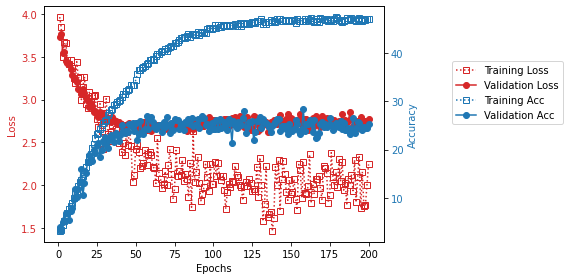

In [22]:
plot_fit_history(hist)
